# Sales Predictor

The aim of this notebook is to predict Big Mart sales, through the use of information about the stores, products, and historical sales data. A machine learning pipeline will be used to automate the iterative processing steps.

This notebook uses the BigMart Sales data: https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

### Load data
The data features descriptions:
- Item_Identifier - unique product ID
- Item_Weight - product weight
- Item_Fat_Content - whether product is low fat or not
- Item_Visibility - the % of the total display area of all products in a store allocated to the particular product
- Item_Type - category the product belongs to
- Outlet_Identifier - Unique store ID
- Outlet_Establishment_Year - year in which store was established
- Outlet_Size - size of the store in terms of ground area covered
- Outlet_Location_Type - city type of where the store is located
- Outlet_Type - whether the outlet is a grocery store or other kind of supermarket
- Item_Outlet_Sales - sales of the product in that particular store. This is the target variable to be predicted.

In [3]:
train_df = pd.read_csv('./train.csv')

In [4]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


### Data preprocessing

In [7]:
# check for null values
train_df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
# null values as a percentage of the data set
train_df.isnull().sum() / len(train_df) * 100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

There are two features with missing values: Item_Weight and Outlet_Size.

Item_Weight is a continuous variable so we can use the mean or median to impute the missing values.

Outlet_Size is a categorical variable and the mode will be used to impute the missing values.

In [9]:
# impute missing Item_Weight values by mean
train_df.Item_Weight.fillna(train_df.Item_Weight.mean(), inplace=True)

# impute missing Outlet_Size values by mode
train_df.Outlet_Size.fillna(train_df.Outlet_Size.mode(), inplace=True)

Convert categorical string variables to numerical values by using one hot encoding, as some ML algorithms only accept numerical input:

In [10]:
# create an object for the OneHotEncoder

OHE = ce.OneHotEncoder(cols=['Item_Fat_Content',
                             'Item_Type',
                             'Outlet_Identifier',
                             'Outlet_Size',
                             'Outlet_Location_Type',
                             'Outlet_Type'],
                        use_cat_names=True)

# encode the categorical variables
train_df = OHE.fit_transform(train_df)

Scale the continuous data so that they all range between 0 and 1, by using the StandardScaler function:

In [11]:
# create an object for the StandardScaler
scaler = StandardScaler()

# fit the Item_MRP
scaler.fit(np.array(train_df.Item_MRP).reshape(-1,1))

# transform the data
train_df.Item_MRP = scaler.transform(np.array(train_df.Item_MRP).reshape(-1,1))

In [12]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_LF,Item_Fat_Content_reg,Item_Visibility,Item_Type_Dairy,Item_Type_Soft Drinks,Item_Type_Meat,Item_Type_Fruits and Vegetables,Item_Type_Household,Item_Type_Baking Goods,Item_Type_Snack Foods,Item_Type_Frozen Foods,Item_Type_Breakfast,Item_Type_Health and Hygiene,Item_Type_Hard Drinks,Item_Type_Canned,Item_Type_Breads,Item_Type_Starchy Foods,Item_Type_Others,Item_Type_Seafood,Item_MRP,Outlet_Identifier_OUT049,Outlet_Identifier_OUT018,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT027,Outlet_Identifier_OUT045,Outlet_Identifier_OUT017,Outlet_Identifier_OUT046,Outlet_Identifier_OUT035,Outlet_Identifier_OUT019,Outlet_Establishment_Year,Outlet_Size_Medium,Outlet_Size_nan,Outlet_Size_High,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 3,Outlet_Location_Type_Tier 2,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,FDA15,9.30,1,0,0,0,0,0.016047,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.747454,1,0,0,0,0,0,0,0,0,0,1999,1,0,0,0,1,0,0,1,0,0,0,3735.1380
1,DRC01,5.92,0,1,0,0,0,0.019278,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.489023,0,1,0,0,0,0,0,0,0,0,2009,1,0,0,0,0,1,0,0,1,0,0,443.4228
2,FDN15,17.50,1,0,0,0,0,0.016760,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.010040,1,0,0,0,0,0,0,0,0,0,1999,1,0,0,0,1,0,0,1,0,0,0,2097.2700
3,FDX07,19.20,0,1,0,0,0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.660050,0,0,1,0,0,0,0,0,0,0,1998,0,1,0,0,0,1,0,0,0,1,0,732.3800
4,NCD19,8.93,1,0,0,0,0,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-1.399220,0,0,0,1,0,0,0,0,0,0,1987,0,0,1,0,0,1,0,1,0,0,0,994.7052


## Model Building
We will build two ML algorithms to predict sales:
- Linear Regression
- Random Forest Regressor

In [13]:
# separate the target feature
train_X = train_df.drop(columns=['Item_Identifier', 'Item_Outlet_Sales'])
train_Y = train_df['Item_Outlet_Sales']

# split the data randomly
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y, test_size = 0.3, random_state=1)

# shape of the train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((5966, 46), (2557, 46), (5966,), (2557,))

In [14]:
# build linear regression model
lr_model = LinearRegression()
lr_model.fit(train_x, train_y)

# predict the target feature on the train and test data
predict_train = lr_model.predict(train_x)
predict_test = lr_model.predict(test_x)

In [15]:
# root mean squared error on the train and test date
print('RMSE on train data: ', mean_squared_error(train_y, predict_train) ** 0.5)
print('RMSE on test data: ', mean_squared_error(test_y, predict_test) ** 0.5)

RMSE on train data:  1130.0176571508202
RMSE on test data:  1123.1718501408789


In [16]:
# train random forest regressor model
rfr_model = RandomForestRegressor(max_depth = 10)
rfr_model.fit(train_x, train_y)

# predict the target feature on the train and test data
predict_train = rfr_model.predict(train_x)
predict_test = rfr_model.predict(test_x)

In [17]:
# root mean squared error on the train and test date
print('RMSE on train data: ', mean_squared_error(train_y, predict_train) ** 0.5)
print('RMSE on test data: ', mean_squared_error(test_y, predict_test) ** 0.5)

RMSE on train data:  900.2911864890704
RMSE on test data:  1083.9465734140445


We can see that the random forest regressor model performs better than the linear regression model. However, there is still large room for improvement.

### Feature Importance
There are 46 features and let's see which are the most important. Not all of these features may be useful for predicting sales and could be dropped to simplify the model but not compromise the model's performance.

In [18]:
len(train_x.columns.values)

46

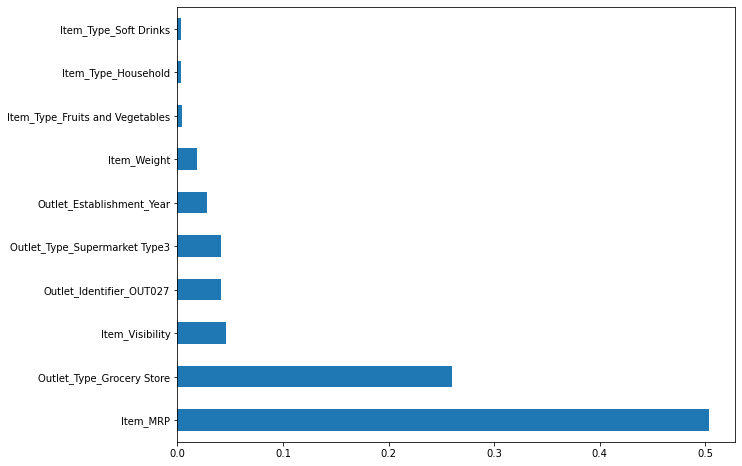

In [19]:
# plot the 10 most importance features
plt.figure(figsize=(10,8))
feature_importance = pd.Series(rfr_model.feature_importances_, index=train_x.columns)
feature_importance.nlargest(10).plot(kind='barh')

In [20]:
# now let's train the random forest regressor model using only the top seven features
train_x_top_feats = train_x[['Item_MRP',
                           'Outlet_Type_Grocery Store',
                           'Item_Visibility',
                           'Outlet_Identifier_OUT027',
                           'Outlet_Type_Supermarket Type3',
                           'Outlet_Establishment_Year',
                           'Item_Weight']]


# test data with top seven features
test_x_top_feats = test_x[['Item_MRP',
                           'Outlet_Type_Grocery Store',
                           'Item_Visibility',
                           'Outlet_Identifier_OUT027',
                           'Outlet_Type_Supermarket Type3',
                           'Outlet_Establishment_Year',
                           'Item_Weight']]

In [21]:
rfr_model_top_feats = RandomForestRegressor(max_depth=10, random_state=1)
rfr_model_top_feats.fit(train_x_top_feats, train_y)

RandomForestRegressor(max_depth=10, random_state=1)

In [22]:
predict_train_top_feats = rfr_model_top_feats.predict(train_x_top_feats)
predict_test_top_feats = rfr_model_top_feats.predict(test_x_top_feats)

In [23]:
# Root Mean Squared Error on the train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train_top_feats)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test_top_feats)**(0.5))

RMSE on train data:  902.1073499063209
RMSE on test data:  1082.7003505925236


Can see that the model performs just as well as the original model with 39 fewer features.

## Build ML Pipeline
Now let's define the structure of the pipeline.

#### Selected Features and Preprocessing Steps

1. Item_MRP - price of the products, a standard scaler was applied during the preprocessing steps
2. Outlet_Type_Grocery_Store - a binary column which indicates if the outlet type is a grocery store or not. To use this information in the model building process, we will add a binary feature in the existing data that contains 1 (if outlet type is a grocery store) and 0 ( if outlet type is something else).
3. Item_Visibility - visibility of products in the store, no preprocessing steps required on this feature
4. Outlet_Type_Supermarket_Type3 - a binary column indicating if the outlet type is a “supermarket_type_3” or not. A binary feature that stores 1 (if outlet type is supermarket_type_3) and 0 (othewise) will be created.
5. Outlet_Identifier_OUT027 - specifies whether the outlet identifier is “OUT027” or not. A separate column that carries 1 (if outlet type is grocery store) and 0 (otherwise) will be created.
6. Outlet_Establishment_Year - year of establishment of the stores, no preprocessings steps required on this feature
7. Item_Weight - missing values were imputed by using the mean

The remaining features will be dropped.

#### Pipeline Design

The three main pipeline stages:
1. Create three binary features using a transformer:
   - Outlet_Type : Grocery Store
   - Outlet_Type : Supermarket Type3
   - Outlet_Identifier_OUT027
2. Perform data preprocessing and transformations using a ColumnTransformer:
    - drop columns that are not required for training the model
    - impute the missing values for the Item_Weight column
    - scale Item_MRP column using StandardScaler() 
3. Build model to predict Item_Outlet_Scales

In [26]:
# import libraries
import pandas as pd
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# load data
data = pd.read_csv('./train.csv')

# separate target feature
train_x = data.drop(columns=['Item_Outlet_Sales'])
train_y = data['Item_Outlet_Sales']

First, let's create three binary columns using a custom transformer by:
1. define a class OutletTypeEncoder
2. add a parameter BaseEstimator when defining the clas
3. class must contain and fit and transform methods

In [27]:
from sklearn.base import BaseEstimator

# custom transformer for 3 binary columns
class OutletTypeEncoder(BaseEstimator):
    
    def __init__(self):
        pass
    
    def fit(self, documents, y=None):
        return self
    
    def transform(self, x_dataset):
        x_dataset['outlet_grocery_store'] = (x_dataset['Outlet_Type'] == 'Grocery Store') * 1
        x_dataset['outlet_supermarket_3'] = (x_dataset['Outlet_Type'] == 'Supermarket Type3') * 1
        x_dataset['outlet_identifier_OUT027'] = (x_dataset['Outlet_Identifier'] == 'OUT027') * 1
        
        return x_dataset

Now to definte the preprocessing steps required before model building:
1. drop columns
2. impute missing values in Item_Weight column with mean
3. scale Item_MRP column using StandardScaler()

In [33]:
# preprocessing step
pre_process = ColumnTransformer(remainder='passthrough',
                                transformers=[('drop_columns', 'drop', ['Item_Identifier',
                                                                        'Outlet_Identifier',
                                                                        'Item_Fat_Content',
                                                                        'Item_Type',
                                                                        'Outlet_Identifier',
                                                                        'Outlet_Size',
                                                                        'Outlet_Location_Type',
                                                                        'Outlet_Type'
                                                                       ]),
                                              ('impute_item_weight', SimpleImputer(strategy='mean'), ['Item_Weight']),
                                              ('scale_data', StandardScaler(),['Item_MRP'])])

Now data is ready to be used to train model.

#### Target prediction
Now to define steps in order for the pipeline object. The fit() function is used with a pipeline object to execute all three steps. After model training, the predict() function is used to generate predictions.

In [34]:
# define the pipeline
"""
Step 1. Create binary columns
Step 2. Pre-processing
Step 3. Train a Random Forest Regressor model
"""
model_pipeline = Pipeline(steps=[('get_outlet_binary_columns', OutletTypeEncoder()),
                                  ('pre-processing', pre_process),
                                  ('random_forest', RandomForestRegressor(max_depth=10, random_state=1))
                                ])

# fit pipeline with the training data
model_pipeline.fit(train_x, train_y)

# predict target values on the training data
model_pipeline.predict(train_x)

array([4344.43409413,  692.08915255, 2301.47745368, ..., 1311.7318012 ,
       1506.46257497, 1168.38548557])

Now load the test data set and use the predict function on the pipeline object to make predictions on the test data.

In [36]:
test_data = pd.read_csv('./test.csv')

model_pipeline.predict(test_data)

array([1590.68184497, 1293.52385787,  645.27557883, ..., 1819.4823537 ,
       3896.92266229, 1362.75813653])